# Multilevel Knowledge-Guided Attention for Modeling Electrocardiography Signals #

Hong, S., Xiao, C., Ma, T., Li, H., & Sun, J. (2019). ***MINA: Multilevel Knowledge-Guided Attention for Modeling Electrocardiography Signals***. *IJCAI 2019*, pp. 5888–5894.

### Introduction
Electrocardiography (ECG) signals are commonly used to diagnose various cardiac abnormalities. Recently, deep learning models showed initial success on modeling ECG data, however they are mostly black-box, thus lack interpretability needed for clinical usage. In this work, we propose MultIlevel kNowledge-guided Attention networks (MINA) that predict heart diseases from ECG signals with intuitive explanation aligned with medical knowledge. By extracting multilevel (beat-, rhythm- and frequency-level) domain knowledge features separately, MINA combines the medical knowledge and ECG data via a multilevel attention model, making the learned models highly interpretable. 

### Using the code in coursework
This code was used for the course work of Artem Vlasov's student of group 23 CST 2 'Classification of arrhythmias by ECG based on in-depth learning'.

### Data and code availability
The 12-lead ECG data set used in this study is the CPSC2018 training dataset which is released by the first China Physiological Signal Challenge (CPSC) 2018 during the seventh International Conference on Biomedical Engineering and Biotechnology. Details of the CPSC2018 dataset can be found at http://2018.icbeb.org/Challenge.html. The source code is provided and is available at https://github.com/hsd1503/MINA?tab=readme-ov-file.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import scipy.io
import scipy.signal as signal
import pickle as dill
from tqdm import tqdm
from time import localtime, strftime
import random

from shutil import copyfile

from sklearn.metrics import log_loss
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

import warnings
from __future__ import print_function
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences  # Для выравнивания длин сигналов
import wfdb
import dill
from glob import glob
import csv
import pywt

from collections import OrderedDict, Counter

import scipy.io
from scipy.signal import butter, lfilter, periodogram

In [ ]:
def preprocess_physionet(data_path, output_path='/kaggle/working/', max_length=9000):
    """
    Обрабатывает PhysioNet ECG Dataset и сохраняет в .pkl
    :param data_path: путь к данным
    :param max_length: длина для padding/truncating сигналов
    """

    # Читаем метки из REFERENCE-v3.csv или labels.csv (зависит от названия вашего файла с метками)
    label_df = pd.read_csv(os.path.join(data_path, 'labels.csv'))
    

    # Читаем список файлов
    labels = label_df.drop(columns=['patient_id', 'fold']).values
    filenames = label_df.iloc[:, 0].values

    all_data = []
    for filename in tqdm(filenames, desc="Чтение .mat файлов"):
        mat = scipy.io.loadmat(os.path.join(data_path, f'{filename}.mat'))
        mat = np.array(mat['val'])[0]  # Берем только первый канал
        all_data.append(mat)

    # Приведение всех последовательностей к одинаковой длине
    all_data = pad_sequences(all_data, maxlen=max_length, padding='post', truncating='post')

    # Сохраняем данные и метки
    res = {'data': all_data, 'label': labels}
    with open(os.path.join(output_path, 'challenge2018.pkl'), 'wb') as fout:
        dill.dump(res, fout)

    print(f"Файл сохранен: {os.path.join(output_path, 'challenge2018.pkl')}")


In [ ]:
def filter_channel(x):
    
    signal_freq = 300
    
    ### candidate channels for ECG
    P_wave = (0.67,5)
    QRS_complex = (10,50)
    T_wave = (1,7)
    muscle = (5,50)
    resp = (0.12,0.5)
    ECG_preprocessed = (0.5, 50)
    wander = (0.001, 0.5)
    noise = 50
    
    ### use low (wander), middle (ECG_preprocessed) and high (noise) for example
    bandpass_list = [wander, ECG_preprocessed]
    highpass_list = [noise]
    
    nyquist_freq = 0.5 * signal_freq
    filter_order = 1
    ### out including original x
    out_list = [x]
    
    for bandpass in bandpass_list:
        low = bandpass[0] / nyquist_freq
        high = bandpass[1] / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, x)
        out_list.append(y)
        
    for highpass in highpass_list:
        high = highpass / nyquist_freq
        b, a = butter(filter_order, high, btype="high")
        y = lfilter(b, a, x)
        out_list.append(y)
        
    out = np.array(out_list)
    
    return out


def slide_and_cut(X, Y, window_size, stride, output_pid=False):
    out_X, out_Y, out_pid = [], [], []
    n_sample = X.shape[0]

    for i in range(n_sample):
        tmp_ts = X[i]
        tmp_Y = Y[i]

        for j in range(0, len(tmp_ts) - window_size, stride):
            out_X.append(tmp_ts[j:j + window_size])
            out_Y.append(tmp_Y)
            out_pid.append(i)

    out_X, out_Y, out_pid = np.array(out_X), np.array(out_Y), np.array(out_pid)

    return (out_X, out_Y, out_pid) if output_pid else (out_X, out_Y)


def compute_beat(X):
    out = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    for i in tqdm(range(out.shape[0]), desc="compute_beat"):
        for j in range(out.shape[1]):
            out[i, j] = np.concatenate([[0], np.abs(np.diff(X[i,j,:]))])
    return out


def compute_rhythm(X, n_split):
    cnt_split = int(X.shape[2]/n_split)
    out = np.zeros((X.shape[0], X.shape[1], cnt_split))
    for i in tqdm(range(out.shape[0]), desc="compute_rhythm"):
        for j in range(out.shape[1]):
            tmp_ts = X[i,j,:]
            tmp_ts_cut = np.split(tmp_ts, X.shape[2]/n_split)
            for k in range(cnt_split):
                out[i, j, k] = np.std(tmp_ts_cut[k])
    return out

def compute_freq(X):
    out = np.zeros((X.shape[0], X.shape[1], 1))
    fs = 300
    for i in tqdm(range(out.shape[0]), desc="compute_freq"):
        for j in range(out.shape[1]):
            _, Pxx_den = periodogram(X[i,j,:], fs)
            out[i, j, 0] = np.sum(Pxx_den)
    return out


def make_data_physionet(data_path, n_split=50, window_size=2000, stride=500, output_path='/kaggle/working/'):
    # Загружаем данные
    with open(os.path.join(output_path, 'challenge2018.pkl'), 'rb') as fin:
        res = dill.load(fin)

    all_data = res['data']
    all_labels_raw = res['label']

    # Нормализация
    for i in range(len(all_data)):
        tmp_data = all_data[i]
        tmp_std = np.std(tmp_data)
        tmp_mean = np.mean(tmp_data)
        all_data[i] = (tmp_data - tmp_mean) / tmp_std

    all_data = np.array(all_data)

    all_label = all_labels_raw
    
    # Делим на train / val / test
    n_sample = len(all_label)
    split_idx_1 = int(0.75 * n_sample)
    split_idx_2 = int(0.85 * n_sample)

    shuffle_idx = np.random.permutation(n_sample)
    all_data = all_data[shuffle_idx]
    all_label = all_label[shuffle_idx]

    X_train, X_val, X_test = all_data[:split_idx_1], all_data[split_idx_1:split_idx_2], all_data[split_idx_2:]
    Y_train, Y_val, Y_test = all_label[:split_idx_1], all_label[split_idx_1:split_idx_2], all_label[split_idx_2:]

    # Разрезаем
    X_train, Y_train = slide_and_cut(X_train, Y_train, window_size=window_size, stride=stride)
    X_val, Y_val = slide_and_cut(X_val, Y_val, window_size=window_size, stride=stride)
    X_test, Y_test, pid_test = slide_and_cut(X_test, Y_test, window_size=window_size, stride=stride, output_pid=True)

    # Перемешиваем train
    shuffle_pid = np.random.permutation(Y_train.shape[0])
    X_train, Y_train = X_train[shuffle_pid], Y_train[shuffle_pid]

    # Обработка каналов
    X_train_ml = np.array([filter_channel(x) for x in tqdm(X_train, desc="X_train_ml")])
    X_val_ml = np.array([filter_channel(x) for x in tqdm(X_val, desc="X_val_ml")])
    X_test_ml = np.array([filter_channel(x) for x in tqdm(X_test, desc="X_test_ml")])

    # Сохраняем
    with open(os.path.join(output_path, 'mina_info.pkl'), 'wb') as fout:
        dill.dump({'Y_train': Y_train, 'Y_val': Y_val, 'Y_test': Y_test, 'pid_test': pid_test}, fout)

    np.save(open(os.path.join(output_path, 'mina_X_train.bin'), 'wb'), X_train_ml)
    np.save(open(os.path.join(output_path, 'mina_X_val.bin'), 'wb'), X_val_ml)
    np.save(open(os.path.join(output_path, 'mina_X_test.bin'), 'wb'), X_test_ml)


def make_knowledge_physionet(data_path, n_split=50, output_path='/kaggle/working/'):

    # read
    fin = open(os.path.join(output_path, 'mina_X_train.bin'), 'rb')
    X_train = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_val.bin'), 'rb')
    X_val = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_test.bin'), 'rb')
    X_test = np.load(fin)
    fin.close()

    # compute knowledge
    K_train_beat = compute_beat(X_train)
    K_train_rhythm = compute_rhythm(X_train, n_split)
    K_train_freq = compute_freq(X_train)

    K_val_beat = compute_beat(X_val)
    K_val_rhythm = compute_rhythm(X_val, n_split)
    K_val_freq = compute_freq(X_val)

    K_test_beat = compute_beat(X_test)
    K_test_rhythm = compute_rhythm(X_test, n_split)
    K_test_freq = compute_freq(X_test)

    # save
    fout = open(os.path.join(output_path, 'mina_K_train_beat.bin'), 'wb')
    np.save(fout, K_train_beat)
    fout.close()
    fout = open(os.path.join(output_path, 'mina_K_val_beat.bin'), 'wb')
    np.save(fout, K_val_beat)
    fout.close()
    fout = open(os.path.join(output_path, 'mina_K_test_beat.bin'), 'wb')
    np.save(fout, K_test_beat)
    fout.close()

    res = {'K_train_rhythm': K_train_rhythm, 'K_train_freq': K_train_freq, 
    'K_val_rhythm': K_val_rhythm, 'K_val_freq': K_val_freq, 
    'K_test_rhythm': K_test_rhythm, 'K_test_freq': K_test_freq}
    with open(os.path.join(output_path, 'mina_knowledge.pkl'), 'wb') as fout:
        dill.dump(res, fout)

In [ ]:
from collections import OrderedDict

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def evaluate(gt, pred, recall, precision, auroc, auprc, f1, accuracy):
    res = OrderedDict()
    
    pred = np.array(pred)
    if not np.allclose(np.sum(pred, axis=1), 1.0, atol=1e-3):
        pred = softmax(pred)  # логиты → вероятности

    try:
        res['auroc'] = roc_auc_score(gt, pred, multi_class='ovr')
        auroc.append(res['auroc'])
    except Exception as e:
        print("ROC AUC error:", e)
        res['auroc'] = None

    try:
        gt_bin = np.eye(pred.shape[1])[gt]  # one-hot представление
        res['auprc'] = average_precision_score(gt_bin, pred, average='macro')
        auprc.append(res['auprc'])
    except Exception as e:
        print("AUPRC error:", e)
        res['auprc'] = None

    pred_label = np.argmax(pred, axis=1)

    res['precision'] = precision_score(gt, pred_label, average='macro', zero_division=0)
    precision.append(res['precision'])

    res['recall'] = recall_score(gt, pred_label, average='macro', zero_division=0)
    recall.append(res['recall'])

    res['f1_score'] = f1_score(gt, pred_label, average='macro', zero_division=0)
    f1.append(res['f1_score'])

    res['accuracy'] = accuracy_score(gt, pred_label)
    accuracy.append(res['accuracy'])

    return res

In [ ]:
class Net(nn.Module):
    def __init__(self, n_channel, n_dim, n_split):
        super(Net, self).__init__()
        
        self.n_channel = n_channel
        self.n_dim = n_dim
        self.n_split = n_split
        self.n_class = 9  # изменено с 2 на 9 для соблюдения единых условий экспериментов
        
        self.base_net_0 = BaseNet(self.n_dim, self.n_split)
        self.base_net_1 = BaseNet(self.n_dim, self.n_split)
        self.base_net_2 = BaseNet(self.n_dim, self.n_split)
        self.base_net_3 = BaseNet(self.n_dim, self.n_split)
            
        ### attention
        self.out_size = 8
        self.att_channel_dim = 2
        self.W_att_channel = nn.Parameter(torch.randn(self.out_size+1, self.att_channel_dim))
        self.v_att_channel = nn.Parameter(torch.randn(self.att_channel_dim, 1))
        
        ### fc
        self.fc = nn.Linear(self.out_size, self.n_class) 
        
    def forward(self, x_0, x_1, x_2, x_3, 
                k_beat_0, k_beat_1, k_beat_2, k_beat_3, 
                k_rhythm_0, k_rhythm_1, k_rhythm_2, k_rhythm_3, 
                k_freq):

        x_0, alpha_0, beta_0 = self.base_net_0(x_0, k_beat_0, k_rhythm_0)
        x_1, alpha_1, beta_1 = self.base_net_1(x_1, k_beat_1, k_rhythm_1)
        x_2, alpha_2, beta_2 = self.base_net_2(x_2, k_beat_2, k_rhythm_2)
        x_3, alpha_3, beta_3 = self.base_net_3(x_3, k_beat_3, k_rhythm_3)
        
        x = torch.stack([x_0, x_1, x_2, x_3], 1)

        ############################################
        ### attention on channel
        ############################################
        k_freq = k_freq.permute(1, 0, 2)
        tmp_x = torch.cat((x, k_freq), dim=-1)
        e = torch.matmul(tmp_x, self.W_att_channel)
        e = torch.matmul(torch.tanh(e), self.v_att_channel)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        gama = torch.div(n1, n2)
        x = torch.sum(torch.mul(gama, x), 1)
        
        ############################################
        ### fc
        ############################################
        x = self.fc(x)  # logits, без softmax
        
        ############################################
        ### return 
        ############################################
        att_dic = {"alpha_0":alpha_0, "beta_0":beta_0, 
                   "alpha_1":alpha_1, "beta_1":beta_1, 
                   "alpha_2":alpha_2, "beta_2":beta_2, 
                   "alpha_3":alpha_3, "beta_3":beta_3, 
                   "gama":gama}
        
        return x, att_dic


In [7]:
class BaseNet(nn.Module):
    def __init__(self, n_dim, n_split):
        super(BaseNet, self).__init__()
        
        self.n_dim = n_dim
        self.n_split = n_split
        self.n_seg = int(n_dim/n_split)
        
        ### Input: (batch size, number of channels, length of signal sequence)
        self.conv_out_channels = 64
        self.conv_kernel_size = 32
        self.conv_stride = 2
        self.conv = nn.Conv1d(in_channels=1, 
                              out_channels=self.conv_out_channels, 
                              kernel_size=self.conv_kernel_size, 
                              stride=self.conv_stride)
        self.conv_k = nn.Conv1d(in_channels=1, 
                                out_channels=1, 
                                kernel_size=self.conv_kernel_size, 
                                stride=self.conv_stride)
        self.att_cnn_dim = 8
        self.W_att_cnn = nn.Parameter(torch.randn(self.conv_out_channels+1, self.att_cnn_dim))
        self.v_att_cnn = nn.Parameter(torch.randn(self.att_cnn_dim, 1))
        
        ### Input: (batch size, length of signal sequence, input_size)
        self.rnn_hidden_size = 32
        self.lstm = nn.LSTM(input_size=(self.conv_out_channels), 
                            hidden_size=self.rnn_hidden_size, 
                            num_layers=1, batch_first=True, bidirectional=True)
        self.att_rnn_dim = 8
        self.W_att_rnn = nn.Parameter(torch.randn(2*self.rnn_hidden_size+1, self.att_rnn_dim))
        self.v_att_rnn = nn.Parameter(torch.randn(self.att_rnn_dim, 1))
        
        ### fc
        self.do = nn.Dropout(p=0.5)
        self.out_size = 8
        self.fc = nn.Linear(2*self.rnn_hidden_size, self.out_size)
    
    def forward(self, x, k_beat, k_rhythm):
        
        self.batch_size = x.size()[0]

        ############################################
        ### reshape
        ############################################
        # print('orignial x:', x.size())
        x = x.view(-1, self.n_split)
        x = x.unsqueeze(1)
        
        k_beat = k_beat.view(-1, self.n_split)
        k_beat = k_beat.unsqueeze(1)
        
        ############################################
        ### conv
        ############################################
        x = F.relu(self.conv(x))
        
        k_beat = F.relu(self.conv_k(k_beat))
        
        ############################################
        ### attention conv
        ############################################
        x = x.permute(0, 2, 1)
        k_beat = k_beat.permute(0, 2, 1)
        tmp_x = torch.cat((x, k_beat), dim=-1)
        e = torch.matmul(tmp_x, self.W_att_cnn)
        e = torch.matmul(torch.tanh(e), self.v_att_cnn)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        alpha = torch.div(n1, n2)
        x = torch.sum(torch.mul(alpha, x), 1)
        
        ############################################
        ### reshape for rnn
        ############################################
        x = x.view(self.batch_size, self.n_seg, -1)
    
        ############################################
        ### rnn        
        ############################################
        
        k_rhythm = k_rhythm.unsqueeze(-1)
        o, (ht, ct) = self.lstm(x)
        tmp_o = torch.cat((o, k_rhythm), dim=-1)
        e = torch.matmul(tmp_o, self.W_att_rnn)
        e = torch.matmul(torch.tanh(e), self.v_att_rnn)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        beta = torch.div(n1, n2)
        x = torch.sum(torch.mul(beta, o), 1)
        
        ############################################
        ### fc
        ############################################
        x = F.relu(self.fc(x))
        x = self.do(x)
        
        return x, alpha, beta        

In [ ]:
def train(model, optimizer, loss_func, epoch, batch_size, 
          X_train, Y_train, K_train_beat, K_train_rhythm, K_train_freq, 
          log_file, loss_metric, auroc_train, auprc_train, f1_score_train, accuracy_train, recall_train, precision_train):
    """
    X_train: (n_channel, n_sample, n_dim)
    Y_train: (n_sample,)
    
    K_train_beat: (n_channel, n_sample, n_dim)
    K_train_rhythm: (n_channel, n_sample, n_dim/n_split)
    K_train_freq: (n_channel, n_sample)
    """
    model.train()
    
    n_train = len(Y_train)
    
    pred_all = []
    batch_start_idx = 0
    batch_end_idx = 0
    loss_all = []
    for _ in tqdm(range(n_train//batch_size+1), desc="train"):
        batch_end_idx = batch_end_idx + batch_size
        if batch_end_idx >= n_train:
            batch_end_idx = n_train
            
        ### input data
        batch_input_0 = Variable(torch.FloatTensor(X_train[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_1 = Variable(torch.FloatTensor(X_train[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_2 = Variable(torch.FloatTensor(X_train[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_3 = Variable(torch.FloatTensor(X_train[3, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### input K_beat
        batch_K_beat_0 = Variable(torch.FloatTensor(K_train_beat[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_1 = Variable(torch.FloatTensor(K_train_beat[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_2 = Variable(torch.FloatTensor(K_train_beat[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_3 = Variable(torch.FloatTensor(K_train_beat[3, batch_start_idx: batch_end_idx, :])).cuda()

        ### input K_rhythm
        batch_K_rhythm_0 = Variable(torch.FloatTensor(K_train_rhythm[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_1 = Variable(torch.FloatTensor(K_train_rhythm[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_2 = Variable(torch.FloatTensor(K_train_rhythm[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_3 = Variable(torch.FloatTensor(K_train_rhythm[3, batch_start_idx: batch_end_idx, :])).cuda()        
        
        ### input K_freq
        batch_K_freq = Variable(torch.FloatTensor(K_train_freq[:, batch_start_idx: batch_end_idx, :])).cuda()  
        
        ### gt
        batch_gt = Variable(torch.LongTensor(Y_train[batch_start_idx: batch_end_idx])).cuda()
        
        pred, _ = model(batch_input_0, batch_input_1, batch_input_2, batch_input_3, 
                        batch_K_beat_0, batch_K_beat_1, batch_K_beat_2, batch_K_beat_3, 
                        batch_K_rhythm_0, batch_K_rhythm_1, batch_K_rhythm_2, batch_K_rhythm_3, 
                        batch_K_freq)
        
        pred_all.append(pred.cpu().data.numpy())
        # print(pred, batch_gt)

        loss = loss_func(pred, batch_gt)
        loss_all.append(loss.cpu().data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_start_idx = batch_start_idx + batch_size

    loss_res = np.mean(loss_all)
    loss_metric.append(loss_res) # добавление в список loss
    print('epoch {0} '.format(epoch))
    print('loss ', np.mean(loss_all))
    print('train | ', end='')
    pred_all = np.concatenate(pred_all, axis=0)
    res = evaluate(Y_train, pred_all, recall_train, precision_train, auroc_train, auprc_train, f1_score_train, accuracy_train)
    res['loss_res'] = loss_res
    res['pred_all'] = pred_all
    
    with open(log_file, 'a') as fout:
        print('epoch {0} '.format(epoch), 'train | ', res, file=fout)
        print('loss_all ', np.mean(loss_all), file=fout)
        
    return res
    

def test(model, batch_size, 
         X_test, Y_test, K_test_beat, K_test_rhythm, K_test_freq, 
         log_file, loss_metric, auroc_test, auprc_test, f1_score_test, accuracy_test, recall_test, precision_test):
    
    model.eval()
    
    n_test = len(Y_test)
    
    pred_all = []
    att_dic_all = []
    
    batch_start_idx = 0
    batch_end_idx = 0
    for _ in tqdm(range(n_test//batch_size+1), desc="test"):
        batch_end_idx = batch_end_idx + batch_size
        if batch_end_idx >= n_test:
            batch_end_idx = n_test
            
        ### input data
        batch_input_0 = Variable(torch.FloatTensor(X_test[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_1 = Variable(torch.FloatTensor(X_test[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_2 = Variable(torch.FloatTensor(X_test[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_3 = Variable(torch.FloatTensor(X_test[3, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### input K_beat
        batch_K_beat_0 = Variable(torch.FloatTensor(K_test_beat[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_1 = Variable(torch.FloatTensor(K_test_beat[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_2 = Variable(torch.FloatTensor(K_test_beat[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_3 = Variable(torch.FloatTensor(K_test_beat[3, batch_start_idx: batch_end_idx, :])).cuda()

        ### input K_rhythm
        batch_K_rhythm_0 = Variable(torch.FloatTensor(K_test_rhythm[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_1 = Variable(torch.FloatTensor(K_test_rhythm[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_2 = Variable(torch.FloatTensor(K_test_rhythm[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_3 = Variable(torch.FloatTensor(K_test_rhythm[3, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### input K_freq
        batch_K_freq = Variable(torch.FloatTensor(K_test_freq[:, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### gt
        batch_gt = Variable(torch.LongTensor(Y_test[batch_start_idx: batch_end_idx])).cuda()

        pred, att_dic = model(batch_input_0, batch_input_1, batch_input_2, batch_input_3, 
                              batch_K_beat_0, batch_K_beat_1, batch_K_beat_2, batch_K_beat_3, 
                              batch_K_rhythm_0, batch_K_rhythm_1, batch_K_rhythm_2, batch_K_rhythm_3, 
                              batch_K_freq)
            
        for k, v in att_dic.items():
            att_dic[k] = v.cpu().data.numpy()
        att_dic_all.append(att_dic)
        pred_all.append(pred.cpu().data.numpy())

        batch_start_idx = batch_start_idx + batch_size

    print('test | ', end='')
    pred_all = np.concatenate(pred_all, axis=0)
    res = evaluate(Y_test, pred_all, recall_test, precision_test, auroc_test, auprc_test, f1_score_test, accuracy_test)
    res['pred_all'] = pred_all
    
    with open(log_file, 'a') as fout:
        print('test | ', res, file=fout)

    return res, att_dic_all

In [ ]:
def run(data_path, loss_metric, 
        aauroc_train, auprc_train, f1_score_train, accuracy_train, recall_train, precision_train,
        auroc_test, auprc_test, f1_score_test, accuracy_test, recall_test, precision_test, output_path='/kaggle/working/'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    n_epoch = 80 # 200
    lr = 0.003
    n_split = 50

    ##################################################################
    ### par
    ##################################################################
    run_id = 'mina_{0}'.format(strftime("%Y-%m-%d-%H-%M-%S", localtime()))
    directory = 'res/{0}'.format(run_id)
    try:
        os.stat('res/')
    except:
        os.mkdir('res/')    
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    
    log_file = '{0}/log.txt'.format(directory)
    model_file = '/kaggle/input/dataset-mina/CPSC/mina.py'
    destination_file = os.path.join(directory, os.path.basename(model_file))

    copyfile(model_file, destination_file)

    n_dim = 2000
    batch_size = 128

    with open(log_file, 'a') as fout:
        print(run_id, file=fout)

    ##################################################################
    ### read data
    ##################################################################
    with open(os.path.join(output_path, 'mina_info.pkl'), 'rb') as fin:
        res = dill.load(fin)    
    Y_train = res['Y_train']
    Y_val = res['Y_val']
    Y_test = res['Y_test']

    fin = open(os.path.join(output_path, 'mina_X_train.bin'), 'rb')
    X_train = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_val.bin'), 'rb')
    X_val = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_test.bin'), 'rb')
    X_test = np.load(fin)
    fin.close()
    X_train = np.swapaxes(X_train, 0, 1)
    X_val = np.swapaxes(X_val, 0, 1)
    X_test = np.swapaxes(X_test, 0, 1)
    print(X_train.shape, X_val.shape, X_test.shape)

    fin = open(os.path.join(output_path, 'mina_K_train_beat.bin'), 'rb')
    K_train_beat = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_K_val_beat.bin'), 'rb')
    K_val_beat = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_K_test_beat.bin'), 'rb')
    K_test_beat = np.load(fin)
    fin.close()
    with open(os.path.join(output_path, 'mina_knowledge.pkl'), 'rb') as fin:
        res = dill.load(fin)    
    K_train_rhythm = res['K_train_rhythm']
    K_train_freq = res['K_train_freq']
    K_val_rhythm = res['K_val_rhythm']
    K_val_freq = res['K_val_freq']
    K_test_rhythm = res['K_test_rhythm']
    K_test_freq = res['K_test_freq']
    K_train_beat = np.swapaxes(K_train_beat, 0, 1)
    K_train_rhythm = np.swapaxes(K_train_rhythm, 0, 1)
    K_train_freq = np.swapaxes(K_train_freq, 0, 1)
    K_val_beat = np.swapaxes(K_val_beat, 0, 1)
    K_val_rhythm = np.swapaxes(K_val_rhythm, 0, 1)
    K_val_freq = np.swapaxes(K_val_freq, 0, 1)
    K_test_beat = np.swapaxes(K_test_beat, 0, 1)
    K_test_rhythm = np.swapaxes(K_test_rhythm, 0, 1)
    K_test_freq = np.swapaxes(K_test_freq, 0, 1)
    print(K_train_beat.shape, K_train_rhythm.shape, K_train_freq.shape)
    print(K_val_beat.shape, K_val_rhythm.shape, K_val_freq.shape)
    print(K_test_beat.shape, K_test_rhythm.shape, K_test_freq.shape)

    print('load data done!')
    
    ##################################################################
    ### train
    ##################################################################

    n_channel = X_train.shape[0]
    print('n_channel:', n_channel)

    torch.cuda.manual_seed(0)

    model = Net(n_channel, n_dim, n_split)
    model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_classes = 9         # количество классов
    if isinstance(Y_train, np.ndarray) and Y_train.ndim > 1 and Y_train.shape[1] == num_classes:
        Y_train = torch.tensor(Y_train)
        Y_train = torch.argmax(Y_train, dim=1)
    
    if isinstance(Y_val, np.ndarray) and Y_val.ndim > 1 and Y_val.shape[1] == num_classes:
        Y_val = torch.tensor(Y_val)
        Y_val = torch.argmax(Y_val, dim=1)
    
    if isinstance(Y_test, np.ndarray) and Y_test.ndim > 1 and Y_test.shape[1] == num_classes:
        Y_test = torch.tensor(Y_test)
        Y_test = torch.argmax(Y_test, dim=1)

    Y_train_onehot = F.one_hot(Y_train, num_classes=num_classes).float()
    class_counts = torch.sum(Y_train_onehot, dim=0)  # shape: [num_classes]
    
    class_counts[class_counts == 0] = 1.0
    
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()  # нормировка
    
    class_weights = class_weights.clone().detach().to(dtype=torch.float32, device=device)
    loss_func = nn.CrossEntropyLoss(weight=class_weights)



    train_res_list = []
    val_res_list = []
    test_res_list = []
    val_att_list = []
    test_att_list = []
    prev_model_path = None  # Храним путь к предыдущей модели
    
    for epoch in range(n_epoch):
        tmp_train = train(model, optimizer, loss_func, epoch, batch_size, 
                          X_train, Y_train, K_train_beat, K_train_rhythm, K_train_freq, 
                          log_file, loss_metric, auroc_train, auprc_train, f1_score_train, accuracy_train, recall_train, precision_train)
        tmp_val, tmp_att_val = test(model, batch_size, 
                                    X_val, Y_val, K_val_beat, K_val_rhythm, K_val_freq, 
                                    log_file, loss_metric, auroc_test, auprc_test, f1_score_test, accuracy_test,recall_test, precision_test)
        tmp_test, tmp_att_test = test(model, batch_size, 
                                      X_test, Y_test, K_test_beat, K_test_rhythm, K_test_freq, 
                                      log_file, loss_metric, auroc_test, auprc_test, f1_score_test, accuracy_test, recall_test, precision_test)
    
        train_res_list.append(tmp_train)
        val_res_list.append(tmp_val)
        test_res_list.append(tmp_test)
        test_att_list.append(tmp_att_test)

        # Удаляем предыдущую сохранённую модель
        if prev_model_path and os.path.exists(prev_model_path):
            os.remove(prev_model_path)
    
        # Сохраняем новую модель
        model_path = '{0}/model_{1}.pt'.format(directory, epoch)
        torch.save(model, model_path)
    
        # Обновляем путь к предыдущей модели
        prev_model_path = model_path
        
    ##################################################################
    ### save results
    ##################################################################
    res_mat = []
    for i in range(n_epoch):
        train_res = train_res_list[i]
        val_res = val_res_list[i]
        test_res = test_res_list[i]
        res_mat.append([
            train_res['loss_res'], train_res['accuracy'],  
            val_res['accuracy'], val_res['f1_score'],      
            test_res['accuracy'], test_res['f1_score']
        ])
    res_mat = np.array(res_mat)
    
    res = {'train_res_list': train_res_list, 
           'val_res_list': val_res_list, 
           'test_res_list': test_res_list}
    with open('{0}/res.pkl'.format(directory), 'wb') as fout:
        dill.dump(res, fout)
    
    np.savetxt('{0}/res_mat.csv'.format(directory), res_mat, delimiter=',')

In [12]:
# prepare data
data_path = '/kaggle/input/dataset-mina/CPSC'
output_path = '/kaggle/working/'

In [13]:
loss_metric = []
auroc_train = []
auprc_train = []
f1_score_train = []
accuracy_train = []
recall_train = []
precision_train = []

auroc_test = []
auprc_test = []
f1_score_test = []
accuracy_test = []
recall_test = []
precision_test = []

### Data preprocessing

In [14]:
preprocess_physionet(data_path)
make_data_physionet(data_path) 
make_knowledge_physionet(data_path)

Загружено 6877 меток, 9 классов.
Файлы: ['A0001' 'A0002' 'A0003' 'A0004' 'A0005']


Чтение .mat файлов: 100%|██████████| 6877/6877 [00:55<00:00, 123.22it/s]


Файл сохранен: /kaggle/working/challenge2018.pkl


compute_freq: 100%|██████████| 14448/14448 [00:10<00:00, 1346.24it/s]


### Model training

In [15]:
# run
for i_run in range(1):
    run(data_path, loss_metric, auroc_train, auprc_train, f1_score_train, accuracy_train, recall_train, precision_train,
        auroc_test, auprc_test, f1_score_test, accuracy_test, recall_test, precision_test)

Using device: cuda
(4, 72198, 2000) (4, 9632, 2000) (4, 14448, 2000)
(4, 72198, 2000) (4, 72198, 40) (4, 72198, 1)
(4, 9632, 2000) (4, 9632, 40) (4, 9632, 1)
(4, 14448, 2000) (4, 14448, 40) (4, 14448, 1)
load data done!
n_channel: 4


train: 100%|██████████| 565/565 [00:12<00:00, 44.39it/s]


epoch 0 
loss  1.9858757
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.76it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 101.68it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 48.71it/s]


epoch 1 
loss  1.8539119
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 103.50it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 101.41it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 48.57it/s]


epoch 2 
loss  1.7835838
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 98.68it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 89.85it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.82it/s]


epoch 3 
loss  1.7437087
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.69it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 99.58it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.16it/s]


epoch 4 
loss  1.7057666
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.61it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 100.32it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.17it/s]


epoch 5 
loss  1.685498
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.90it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 98.50it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.68it/s]


epoch 6 
loss  1.6615711
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.72it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.62it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.91it/s]


epoch 7 
loss  1.6418483
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.21it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 98.78it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.42it/s]


epoch 8 
loss  1.623242
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 97.57it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 98.60it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.61it/s]


epoch 9 
loss  1.6088476
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.17it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.07it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.31it/s]


epoch 10 
loss  1.5993934
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.95it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 98.29it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.72it/s]


epoch 11 
loss  1.5860912
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.64it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.65it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.54it/s]


epoch 12 
loss  1.5732712
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.70it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.38it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.51it/s]


epoch 13 
loss  1.5589738
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.48it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.99it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.52it/s]


epoch 14 
loss  1.5520341
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.19it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.30it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 47.00it/s]


epoch 15 
loss  1.5397383
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.78it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 87.58it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.31it/s]


epoch 16 
loss  1.5320874
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.17it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.80it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.16it/s]


epoch 17 
loss  1.5256423
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.63it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.24it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.38it/s]


epoch 18 
loss  1.5155632
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.30it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.77it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.97it/s]


epoch 19 
loss  1.504379
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.65it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.78it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.82it/s]


epoch 20 
loss  1.5035148
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.55it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.52it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.56it/s]


epoch 21 
loss  1.4893949
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.60it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.78it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.46it/s]


epoch 22 
loss  1.4763558
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 90.92it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.45it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.64it/s]


epoch 23 
loss  1.4782943
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.13it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.58it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.31it/s]


epoch 24 
loss  1.4631273
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.77it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.50it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.84it/s]


epoch 25 
loss  1.4534769
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.53it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.90it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.17it/s]


epoch 26 
loss  1.4480815
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 85.81it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 91.46it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 48.07it/s]


epoch 27 
loss  1.4383457
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 91.60it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 98.92it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.30it/s]


epoch 28 
loss  1.433554
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.60it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.53it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.18it/s]


epoch 29 
loss  1.4273466
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.88it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.66it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 47.04it/s]


epoch 30 
loss  1.4264975
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.93it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.48it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.52it/s]


epoch 31 
loss  1.423258
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.45it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.28it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.16it/s]


epoch 32 
loss  1.4104835
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.63it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.26it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.44it/s]


epoch 33 
loss  1.4113634
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.91it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.23it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.48it/s]


epoch 34 
loss  1.4097911
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.63it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 97.65it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.09it/s]


epoch 35 
loss  1.4067322
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 91.41it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.03it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.14it/s]


epoch 36 
loss  1.3907316
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.25it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.99it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.51it/s]


epoch 37 
loss  1.3746808
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.69it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.87it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.19it/s]


epoch 38 
loss  1.3879888
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.32it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 92.11it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 47.04it/s]


epoch 39 
loss  1.3798845
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 86.28it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.63it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.12it/s]


epoch 40 
loss  1.3663775
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.36it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.04it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.15it/s]


epoch 41 
loss  1.3689088
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 96.07it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.67it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.26it/s]


epoch 42 
loss  1.3667629
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.06it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.06it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.45it/s]


epoch 43 
loss  1.3530489
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.90it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 92.44it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.28it/s]


epoch 44 
loss  1.3591012
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.31it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.41it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.06it/s]


epoch 45 
loss  1.3517462
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 91.51it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.24it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.55it/s]


epoch 46 
loss  1.3407089
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.18it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.05it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.97it/s]


epoch 47 
loss  1.3768855
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.16it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.80it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.64it/s]


epoch 48 
loss  1.354286
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.01it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 93.07it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.42it/s]


epoch 49 
loss  1.339013
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 89.06it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 91.85it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 44.95it/s]


epoch 50 
loss  1.3310618
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.00it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.96it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.62it/s]


epoch 51 
loss  1.3235011
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.48it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.26it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.77it/s]


epoch 52 
loss  1.3436904
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.88it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.26it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.35it/s]


epoch 53 
loss  1.3292582
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.69it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.65it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.11it/s]


epoch 54 
loss  1.3103254
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 91.13it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.83it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.57it/s]


epoch 55 
loss  1.3073423
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.91it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 93.78it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.30it/s]


epoch 56 
loss  1.3278247
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.37it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 89.64it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 47.05it/s]


epoch 57 
loss  1.3293369
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 95.93it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 96.11it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.97it/s]


epoch 58 
loss  1.309074
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.94it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.14it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.32it/s]


epoch 59 
loss  1.3019775
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 91.86it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.48it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.67it/s]


epoch 60 
loss  1.2946538
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 87.64it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.96it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.20it/s]


epoch 61 
loss  1.2950666
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.18it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.88it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.74it/s]


epoch 62 
loss  1.310478
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 89.71it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.21it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.90it/s]


epoch 63 
loss  1.3100775
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.07it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 93.44it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.26it/s]


epoch 64 
loss  1.2812476
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 89.32it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.72it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.37it/s]


epoch 65 
loss  1.283883
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.60it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.31it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.32it/s]


epoch 66 
loss  1.2895018
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 90.07it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.42it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.25it/s]


epoch 67 
loss  1.2781541
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 91.40it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 93.95it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.19it/s]


epoch 68 
loss  1.2774405
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 89.32it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 95.35it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.32it/s]


epoch 69 
loss  1.270194
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.38it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.67it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.55it/s]


epoch 70 
loss  1.2893804
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.37it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 92.86it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.94it/s]


epoch 71 
loss  1.2811695
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 85.64it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 88.43it/s]


test | 

train: 100%|██████████| 565/565 [00:11<00:00, 47.21it/s]


epoch 72 
loss  1.2838249
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 93.40it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.52it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.38it/s]


epoch 73 
loss  1.2783425
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.90it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.73it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.97it/s]


epoch 74 
loss  1.2598838
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.91it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 92.71it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.96it/s]


epoch 75 
loss  1.2612196
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.58it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 93.20it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.22it/s]


epoch 76 
loss  1.2605739
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.35it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 92.88it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 45.76it/s]


epoch 77 
loss  1.2446107
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 94.14it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.98it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 44.24it/s]


epoch 78 
loss  1.2473226
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.76it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 92.79it/s]


test | 

train: 100%|██████████| 565/565 [00:12<00:00, 46.53it/s]


epoch 79 
loss  1.2558862
train | 

test: 100%|██████████| 76/76 [00:00<00:00, 92.84it/s]


test | 

test: 100%|██████████| 113/113 [00:01<00:00, 94.48it/s]


test | 

### Metrics

In [ ]:
# Создаём список эпох (по длине списка метрик)
epochs = list(range(len(loss_metric)))

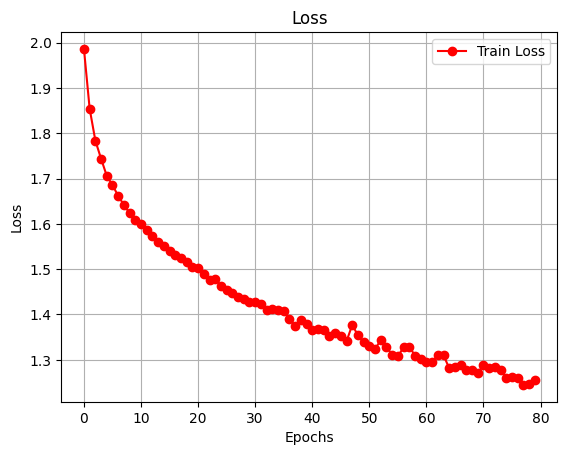

In [17]:
# Loss
plt.plot(epochs, loss_metric, label="Train Loss", color="red", marker="o")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [18]:
loss_metric = np.array(loss_metric)
print(f"Среднее значение loss: {np.mean(loss_metric)}")

Среднее значение loss: 1.4219634532928467


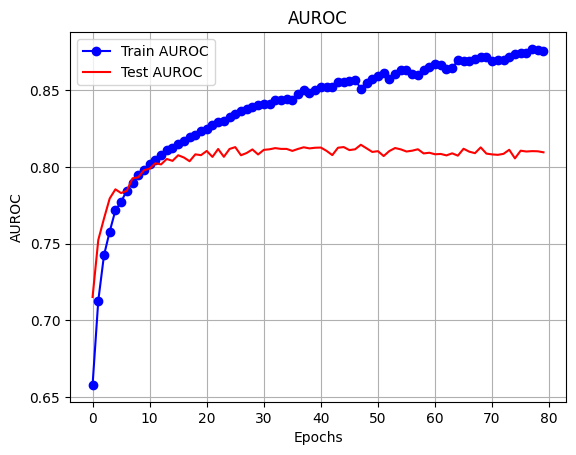

In [19]:
# AUROC
plt.plot(epochs, auroc_train, label="Train AUROC", color="blue", marker="o")
plt.plot(epochs, auroc_test[1::2], label="Test AUROC", color="red")
plt.title("AUROC")
plt.xlabel("Epochs")
plt.ylabel("AUROC")
plt.legend()
plt.grid()
plt.show()

In [20]:
auroc_train = np.array(auroc_train)
print(f"Среднее значение auroc при обучении модели {np.mean(auroc_train)}")
auroc_test = np.array(auroc_test[1::2])
print(f"Среднее значение auroc при тестировании модели {np.mean(auroc_train)}")

Среднее значение auroc при обучении модели 0.8383803472558234
Среднее значение auroc при тестировании модели 0.8383803472558234


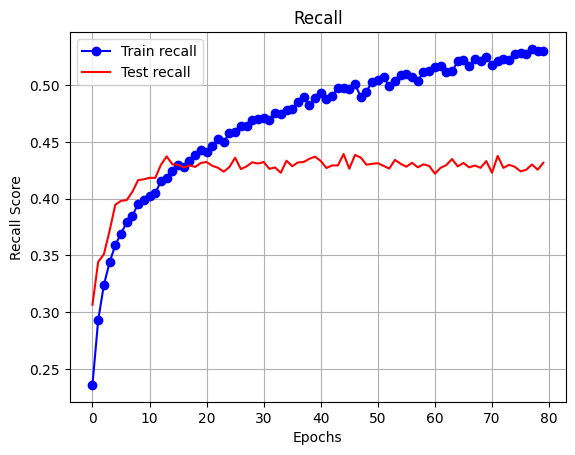

In [27]:
plt.plot(epochs, recall_train, label="Train recall", color="blue", marker="o")
plt.plot(epochs, recall_test[1::2], label="Test recall", color="red")
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall Score")
plt.legend()
plt.grid()
plt.show()

In [28]:
recall_data_test = np.array(recall_test[1::2])
print(f"Среднее значение Recall при тестировании модели {np.mean(recall_data_test)}")

Среднее значение Recall при тестировании модели 0.4235384327150765


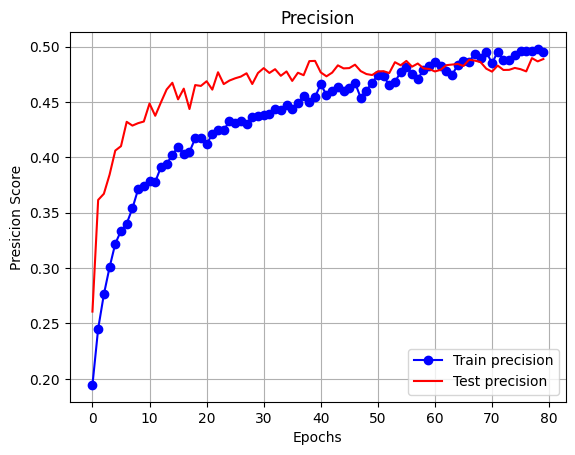

In [29]:
plt.plot(epochs, precision_train, label="Train precision", color="blue", marker="o")
plt.plot(epochs, precision_test[1::2], label="Test precision", color="red")
plt.title("Precision")
plt.xlabel("Epochs")
plt.ylabel("Presicion Score")
plt.legend()
plt.grid()
plt.show()

In [30]:
precision_data_test = np.array(precision_test[1::2])
print(f"Среднее значение Recall при тестировании модели {np.mean(precision_data_test)}")

Среднее значение Recall при тестировании модели 0.46510420344469827


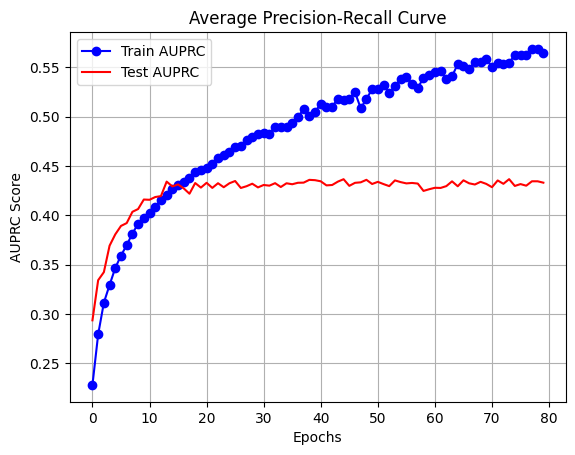

In [21]:
# AUPRC
plt.plot(epochs, auprc_train, label="Train AUPRC", color="blue", marker="o")
plt.plot(epochs, auprc_test[1::2], label="Test AUPRC", color="red")
plt.title("Average Precision-Recall Curve")
plt.xlabel("Epochs")
plt.ylabel("AUPRC Score")
plt.legend()
plt.grid()
plt.show()

In [22]:
auprc_train = np.array(auprc_train)
print(f"Среднее значение Average Precision-Recall Curve при обучении модели {np.mean(auprc_train)}")
auprc_test = np.array(auprc_test[1::2])
print(f"Среднее значение Average Precision-Recall Curve при тестировании модели {np.mean(auprc_test)}")

Среднее значение Average Precision-Recall Curve при обучении модели 0.4858277447630748
Среднее значение Average Precision-Recall Curve при тестировании модели 0.4237783191745019


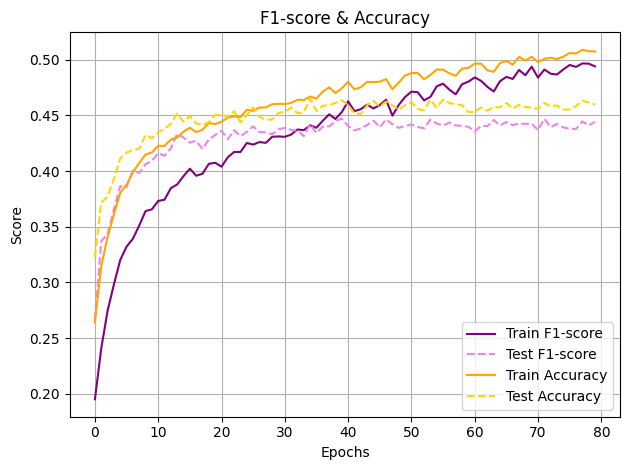

In [23]:
# F1-score & Accuracy
plt.plot(epochs, f1_score_train, label="Train F1-score", color="purple")
plt.plot(epochs, f1_score_test[1::2], label="Test F1-score", color="violet", linestyle="dashed")
plt.plot(epochs, accuracy_train, label="Train Accuracy", color="orange")
plt.plot(epochs, accuracy_test[1::2], label="Test Accuracy", color="gold", linestyle="dashed")
plt.title("F1-score & Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid()

# Отображаем графики
plt.tight_layout()
plt.show()
plt.show()

In [24]:
f1_score_train = np.array(f1_score_train)
print(f"Среднее значение F1 при обучении модели {np.mean(f1_score_train)}")
f1_score_test = np.array(f1_score_test[1::2])
print(f"Среднее значение F1 при тестировании модели {np.mean(f1_score_test)}")

Среднее значение F1 при обучении модели 0.43362661533441377
Среднее значение F1 при тестировании модели 0.429154716567297


In [25]:
accuracy_train = np.array(accuracy_train)
print(f"Среднее значение Accuracy при обучении модели {np.mean(accuracy_train)}")
accuracy_test = np.array(accuracy_test[1::2])
print(f"Среднее значение Accuracy при тестировании модели {np.mean(accuracy_test)}")

Среднее значение Accuracy при обучении модели 0.4613493448571983
Среднее значение Accuracy при тестировании модели 0.44785956533776294


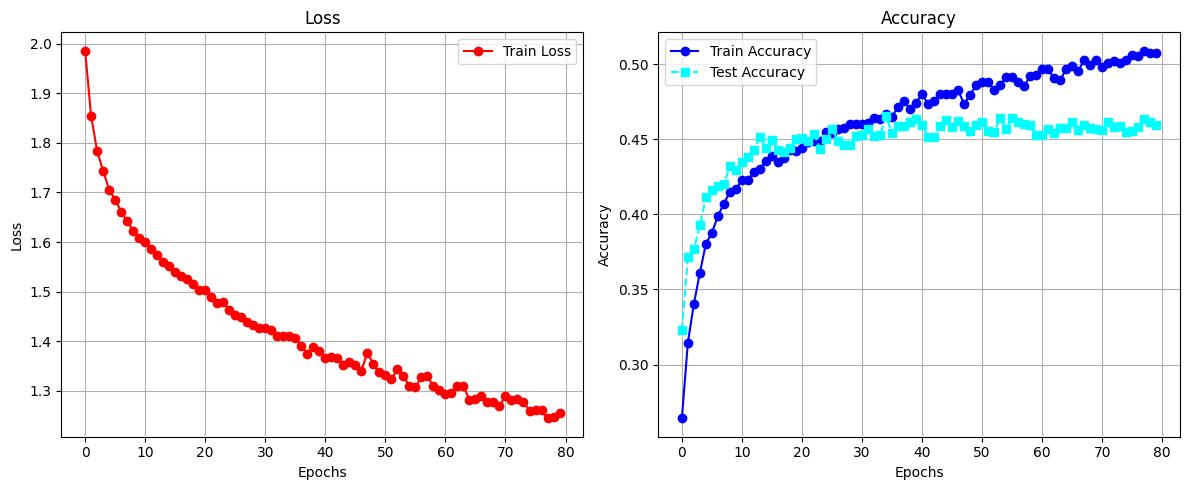

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# График Loss
axs[0].plot(epochs, loss_metric, label="Train Loss", color="red", marker="o")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

# График Accuracy
axs[1].plot(epochs, accuracy_train, label="Train Accuracy", color="blue", marker="o")
axs[1].plot(epochs, accuracy_test, label="Test Accuracy", color="cyan", linestyle="dashed", marker="s")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()
